# Bitcoin - Buy or Sell?

## Load and Clean Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import fbprophet
import math
import pmdarima as pm

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data to forecast
bitcoin = pd.read_csv('yahoo_BTC-USD_d_train.csv')

# Load external variables/features
cpi = pd.read_csv('yahoo_CPI_d.csv')
dow = pd.read_csv('yahoo_DJI_d.csv')
sp = pd.read_csv('yahoo_SP500_d.csv')
usd = pd.read_csv('yahoo_USD_d.csv')
vix = pd.read_csv('yahoo_VIX_d.csv')
interest = pd.read_csv('fed_interest_rates_us.csv')
trend = pd.read_csv('trend_bitcoin.csv')
unemploy = pd.read_csv('fed_bls_unemployment_us.csv')

# Load actual data to evaluate forecast
actual = pd.read_csv('yahoo_BTC-USD_d_test.csv')

In [3]:
# Add time series 'date' column to actual data frame
actual['date'] = pd.to_datetime(actual['Date'])

# Drop unwanted columns
actual.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Rename column
actual.rename(columns={'Close': 'actual_close'}, inplace=True)

# Drop missing values
actual.dropna(inplace=True)

# Check data frame
actual

,actual_close,date
0,7200.174316,2020-01-01
1,6985.470215,2020-01-02
2,7344.884277,2020-01-03
3,7410.656738,2020-01-04
4,7411.317383,2020-01-05
...,...,...
96,7271.781250,2020-04-06
97,7176.414551,2020-04-07
98,7334.098633,2020-04-08
99,7302.089355,2020-04-09


In [4]:
# Add time series 'date' column to unemployment data frame
unemploy['date'] = pd.date_range(start='2014-01-01', end='2020-03-01', normalize=True, freq='MS')

# Drop unwanted column
unemploy.drop(['Series ID', 'Year', 'Period'], axis=1, inplace=True)

# Rename column
unemploy.rename(columns={'Value': 'unemploy'}, inplace=True)

# Check data frame
unemploy.head()

,unemploy,date
0,6.6,2014-01-01
1,6.7,2014-02-01
2,6.7,2014-03-01
3,6.2,2014-04-01
4,6.3,2014-05-01


In [5]:
# Add time series 'date' column to trend data frame
trend['date'] = pd.to_datetime(trend['Month'])

# Drop unwanted column
trend.drop('Month', axis=1, inplace=True)

# Rename column
trend.rename(columns={'bitcoin: (Worldwide)': 'trend'}, inplace=True)

# Check data frame
trend.head()

,trend,date
0,3,2014-12-01
1,3,2015-01-01
2,3,2015-02-01
3,3,2015-03-01
4,2,2015-04-01


In [6]:
# Add time series 'date' column to interest data frame
interest['date'] = pd.to_datetime(interest['Series Description'])

# Drop unwanted columns
col_to_drop = interest.columns.to_list()
col_to_drop.remove('Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis')
col_to_drop.remove('date')

interest.drop(col_to_drop, axis=1, inplace=True)

# Rename column to interest
interest.rename(columns={'Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis': 'interest'}, inplace=True)

# Make interest data numeric
interest['interest'] = pd.to_numeric(interest['interest'], errors='coerce')

# Check data frame
interest.head()

,interest,date
0,0.01,2014-12-01
1,0.04,2014-12-02
2,0.03,2014-12-03
3,0.03,2014-12-04
4,0.02,2014-12-05


In [7]:
# Make list of data frames that need to be cleaned
# and list of columns to drop
df_to_clean = [bitcoin, cpi, dow, sp, usd, vix]
col_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Rename 'Date' column to 'date', clarify 'Close' column,
# change 'date' column from object to datetime, and drop
# unwanted columns
for i, df in enumerate(df_to_clean):
    name_list = ['bitcoin', 'cpi', 'dow', 'sp', 'usd', 'vix']
    df.rename(columns={'Date': 'date', 'Close': '{}_close'.format(name_list[i])}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(col_to_drop, axis=1, inplace=True)

# bitcoin.rename(columns={'Date': 'date', 'Close': 'bitcoin_close'}, inplace=True)
# cpi.rename(columns={'Date': 'date', 'Close': 'cpi_close'}, inplace=True)
# dow.rename(columns={'Date': 'date', 'Close': 'dow_close'}, inplace=True)
# sp.rename(columns={'Date': 'date', 'Close': 'sp_close'}, inplace=True)
# usd.rename(columns={'Date': 'date', 'Close': 'usd_close'}, inplace=True)
# vix.rename(columns={'Date': 'date', 'Close': 'vix_close'}, inplace=True)
    
# bitcoin['date'] = pd.to_datetime(bitcoin['date'])
# cpi['date'] = pd.to_datetime(cpi['date'])
# dow['date'] = pd.to_datetime(dow['date'])
# sp['date'] = pd.to_datetime(sp['date'])
# usd['date'] = pd.to_datetime(usd['date'])
# vix['date'] = pd.to_datetime(vix['date'])

# bitcoin.drop(col_to_drop, axis=1, inplace=True)
# cpi.drop(col_to_drop, axis=1, inplace=True)
# dow.drop(col_to_drop, axis=1, inplace=True)
# sp.drop(col_to_drop, axis=1, inplace=True)
# usd.drop(col_to_drop, axis=1, inplace=True)
# vix.drop(col_to_drop, axis=1, inplace=True)

In [8]:
# Check data frames
bitcoin.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [9]:
cpi.head()

,date,cpi_close
0,2014-12-01,26.660000
1,2014-12-02,26.690001
2,2014-12-03,26.750000
3,2014-12-04,26.670000
4,2014-12-05,26.680000


In [10]:
dow.head()

,date,dow_close
0,2014-12-01,17776.800781
1,2014-12-02,17879.550781
2,2014-12-03,17912.619141
3,2014-12-04,17900.099609
4,2014-12-05,17958.789063


In [11]:
sp.head()

,date,sp_close
0,2014-12-01,2053.439941
1,2014-12-02,2066.550049
2,2014-12-03,2074.330078
3,2014-12-04,2071.919922
4,2014-12-05,2075.370117


In [12]:
usd.head()

,date,usd_close
0,2014-12-01,87.949997
1,2014-12-02,88.650002
2,2014-12-03,88.959999
3,2014-12-04,88.699997
4,2014-12-05,89.330002


In [13]:
vix.head()

,date,vix_close
0,2014-12-01,14.16
1,2014-12-02,12.85
2,2014-12-03,12.50
3,2014-12-04,12.38
4,2014-12-05,11.89


In [14]:
# Make final data frame to store all variables of interest
final = bitcoin[['date', 'bitcoin_close']].copy()
final.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [15]:
# Merge all data frames into one
df_to_merge = [cpi, dow, sp, usd, vix]
for i, df in enumerate(df_to_merge):
    name_list = ['cpi', 'dow', 'sp', 'usd', 'vix']
    final = final.merge(df[['date', '{}_close'.format(name_list[i])]], how='inner', on='date')
    
# final = final.merge(cpi[['date','cpi_close']], how='inner', left_on='date', right_on='date')
# final = final.merge(dow[['date','dow_close']], how='inner', left_on='date', right_on='date')
# final = final.merge(sp[['date','sp_close']], how='inner', left_on='date', right_on='date')
# final = final.merge(usd[['date','usd_close']], how='inner', left_on='date', right_on='date')
# final = final.merge(vix[['date','vix_close']], how='inner', left_on='date', right_on='date')

final = final.merge(interest[['date','interest']], how='inner', left_on='date', right_on='date')
final = final.merge(trend[['date','trend']], how='left', left_on='date', right_on='date')
final = final.merge(unemploy[['date','unemploy']], how='left', left_on='date', right_on='date')

# Check data types
final.dtypes

date             datetime64[ns]
bitcoin_close           float64
cpi_close               float64
dow_close               float64
sp_close                float64
usd_close               float64
vix_close               float64
interest                float64
trend                   float64
unemploy                float64
dtype: object

In [16]:
# Use forward fill to fill in missing trend values
final['trend'].ffill(inplace=True)

# Use forward fill to fill in missing unemploy values
final['unemploy'].ffill(inplace=True)

In [17]:
# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28.469999,28515.449219,3223.379883,NaN,12.67,1.55,11.0,3.5
1274,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1275,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1276,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


In [18]:
# Check for any remaining missing values
final.isnull().sum()

date             0
bitcoin_close    0
cpi_close        0
dow_close        0
sp_close         0
usd_close        9
vix_close        0
interest         7
trend            0
unemploy         0
dtype: int64

In [19]:
# Drop missing values (very small percentage of data)
final.dropna(inplace=True)

# Reset index
final.reset_index(inplace=True, drop=True)

# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1257,2019-12-23,7355.628418,28.450001,28551.529297,3224.010010,97.680000,12.61,1.57,11.0,3.5
1258,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1259,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1260,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


This the the final data frame from which I will pull for the remaining analyses.

## Explore Data

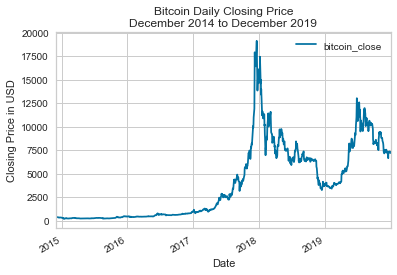

In [20]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

Since bitcoin (and cryptocurrency in general) didn't really explode until mid-2017, the historical data is a bit limited. The time series above suggests that there may be some seasonality, perhaps yearly, but it is difficult to tell with only about 1.5 seasons.

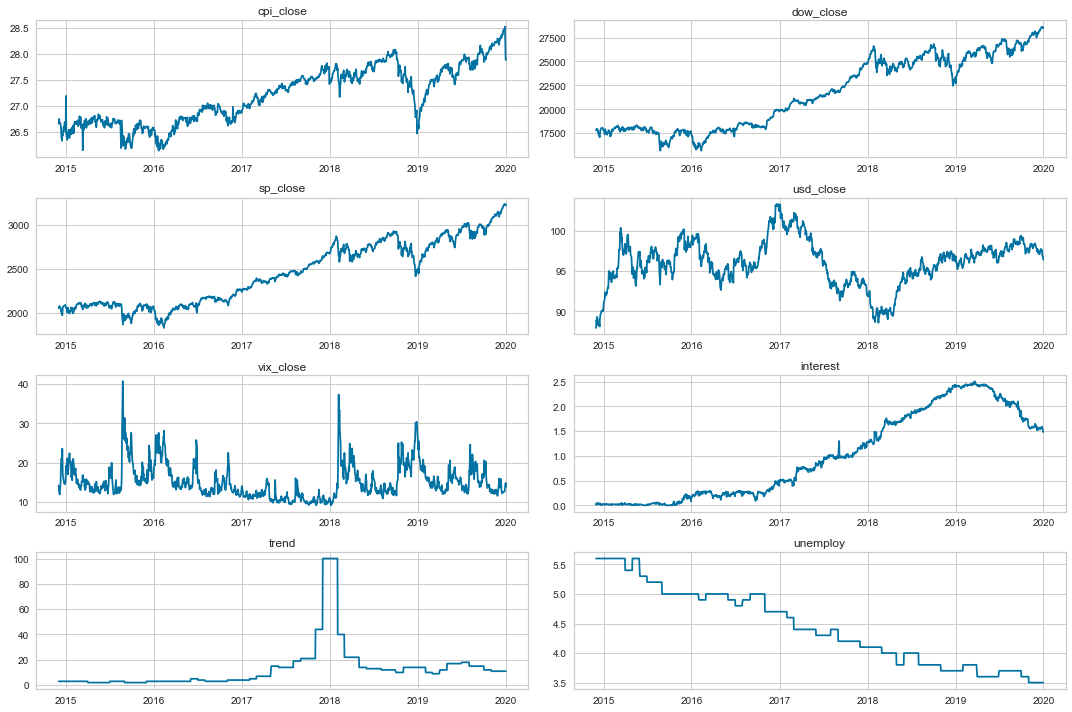

In [21]:
# Plot 8 external variables
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    plt.plot(final['date'], final[col])
    plt.title(col)

# Show plots
plt.tight_layout()
plt.show()

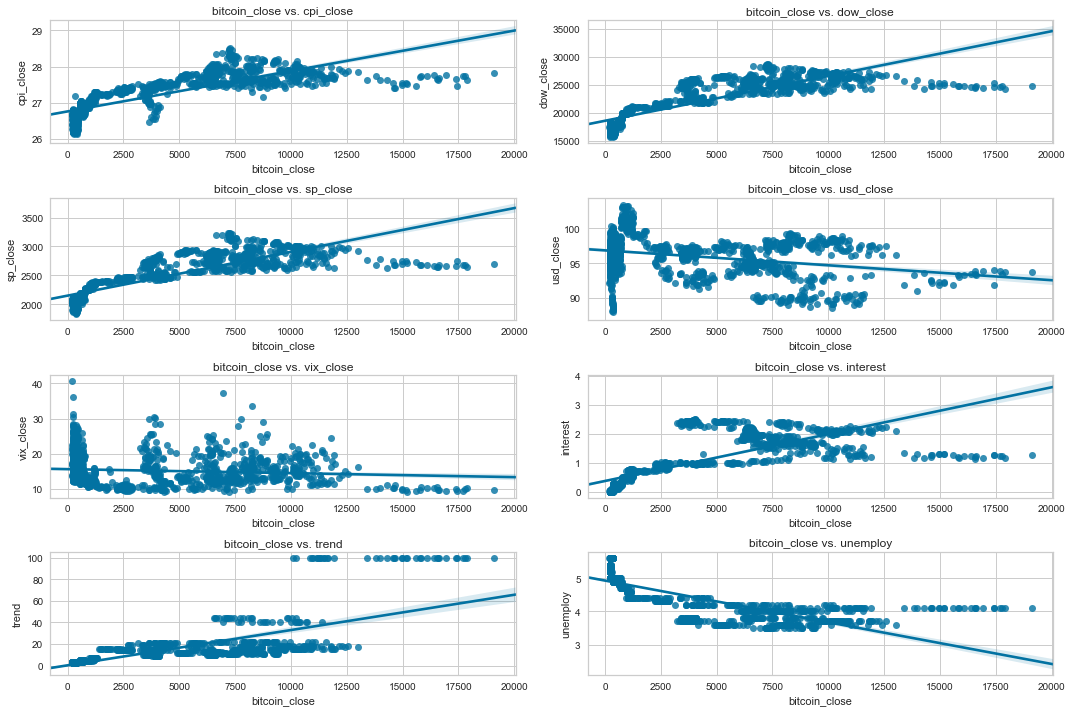

In [22]:
# Plot bitcoin vs. 8 external variables to evaluate
# bivariate relationships
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    sns.regplot(x=final['bitcoin_close'], y=final[col])
    plt.title('bitcoin_close vs. ' + col)
    plt.xlabel('bitcoin_close')
    plt.ylabel(col)

# Show plots
plt.tight_layout()
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


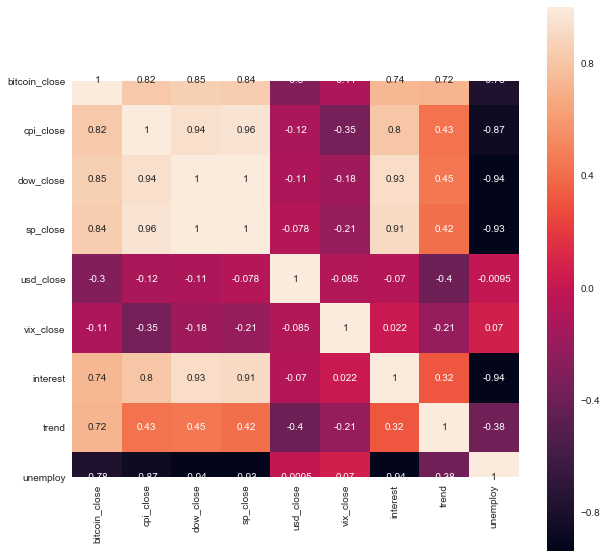

In [23]:
# Plot correlation matrix as heat meap
corr_mat = final.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, square=True)

plt.show()

As demonstrated in the univariate plots, bivariate plots, and correlation matrix heatmap, the closing bitcoin price is most closely associated with google search trend (0.72), interest rate (0.74), S&P500 closing price (0.84), DOW closing price (0.85), and CPI closing price (0.82). Interest rate, S&P50 closing price, DOW closing price, and CPI closing price are also highly correlated with each other.

## Build and Evaluate Models

### Facebook Prophet Model
First, I will forecast the closing price of bitcoin using the Facebook Prophet model. This is an additive model. Generally speaking, it works via a process of curve-fitting, which is in contrast to other time series models, such as ARIMA, that rely on temporal dependencies within the data. I have chosen not to correct for seasonality since the data is limited.

In [24]:
# Create new data frame for bitcoin prices
gm = final[['date', 'bitcoin_close']].copy()
gm.rename(columns={'date': 'ds', 'bitcoin_close': 'y'}, inplace=True)

# Check end of data frame
gm.tail()

,ds,y
1257,2019-12-23,7355.628418
1258,2019-12-26,7238.966797
1259,2019-12-27,7290.088379
1260,2019-12-30,7292.995117
1261,2019-12-31,7193.599121


In [25]:
# Instantiate new prophet object and fit model
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, daily_seasonality=False)
gm_prophet.fit(gm)

# Use model to forecast daily bitcoin prices 90
# days into the future
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
gm_forecast = gm_prophet.predict(gm_forecast)

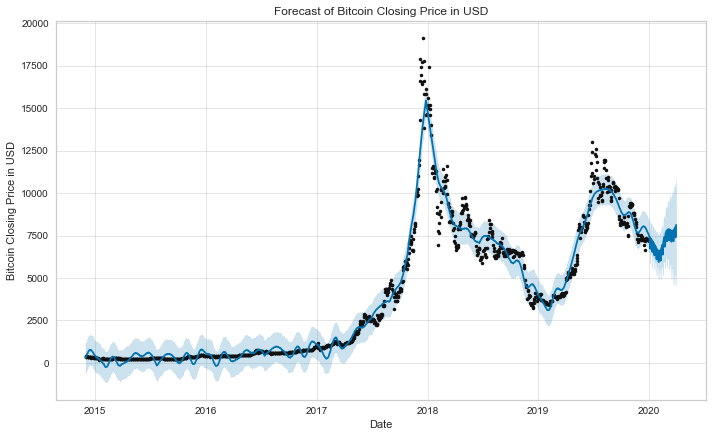

In [26]:
# Plot the actual prices along with the forecast
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

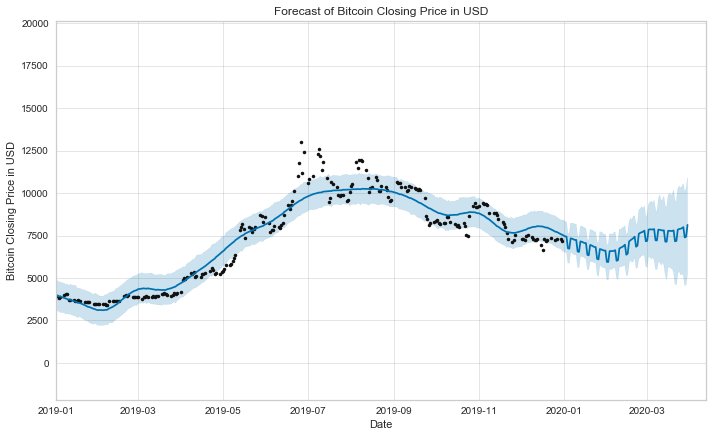

In [27]:
# Zoom in on the years 2019 and 2020
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.xlim([datetime.date(2019, 1, 1)], [datetime.date(2020, 4, 12)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

I used the changepoint_prior_scale parameter to tune the flexibility of the model. If the model was overfittting (too much flexibility), I decreased the changepoint prior scale, and if it was underfitting (too little flexibility), I increased the changepoint prior scale. I settled on a value of 0.2 (default is 0.05).

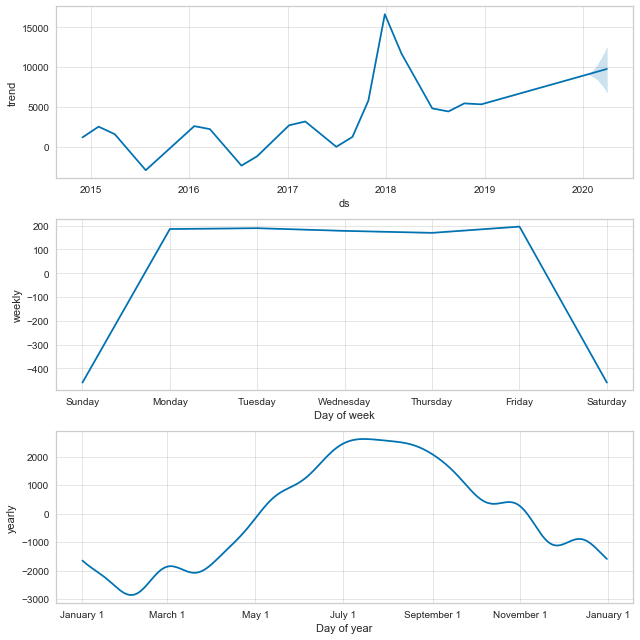

In [28]:
# Look at the trend and seasonality components of
# the bitcoin forecast
gm_prophet.plot_components(gm_forecast);

# HELP: What do these plots tell me? Can I change anything based on these plots to make my model better?

The trend component fits nicely with the google search trend plot, which shows that interest in bitcoin peaked in 2018. The weekly component fits with the data set, which is missing closing prices on the weekends due to the stock market being closed. Finally, the yearly component indicates that bitcoin closing prices are affected by the month, with negative incremental effects seen in the winter (December-March) and positive incremental effects seen in the summer (June-August).

In [29]:
# Store forecasted prices in a data frame
fbp = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp.rename(columns={'ds': 'date', 'yhat': 'fbp_forecast'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [30]:
# Add forecasted prices to actual data frame for comparison
actual = actual.merge(fbp, how='inner', left_on='date', right_on='date')
actual

,actual_close,date,fbp_forecast
0,7200.174316,2020-01-01,7491.324569
1,6985.470215,2020-01-02,7447.081397
2,7344.884277,2020-01-03,7439.084870
3,7410.656738,2020-01-04,6749.852761
4,7411.317383,2020-01-05,6719.003168
...,...,...,...
85,6716.440430,2020-03-26,7928.519463
86,6469.798340,2020-03-27,7995.008030
87,6242.193848,2020-03-28,7382.027573
88,5922.042969,2020-03-29,7428.896153


In [31]:
# Use RMSE and MAE to evaluate performance of prophet model
print('Facebook Prophet Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['fbp_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['fbp_forecast']))

Facebook Prophet Performance

Root mean squared error: 2131.68

Mean absolute error: 1894.42


# HELP: TO DO

### Facebook Prophet Model with Additional Regressor
Second, I will use known and forecasted Dow closing prices (most highly correlated with bitcoin closing prices) as an additional regressor in the Facebook Prophet model to hopefully more accurately forecast bitcoin prices.

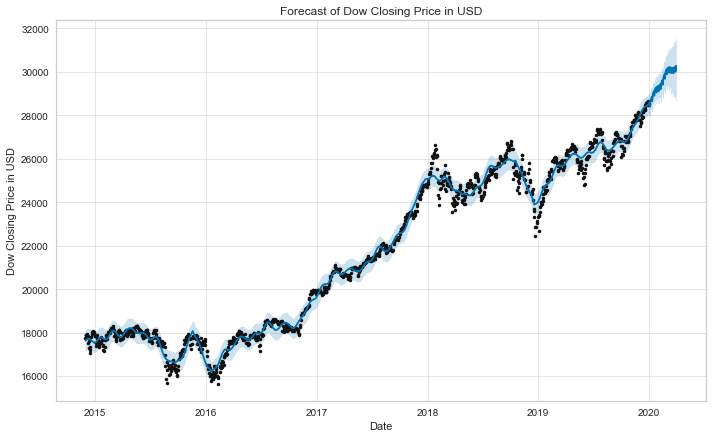

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


,date,fbp_dow_forecast
1262,2020-01-01,28543.945061
1263,2020-01-02,28576.539369
1264,2020-01-03,28607.365755
1265,2020-01-04,28383.802982
1266,2020-01-05,28415.683235
...,...,...
1347,2020-03-26,30224.865731
1348,2020-03-27,30242.578246
1349,2020-03-28,30005.109388
1350,2020-03-29,30022.303882


In [32]:
# Create new data frame for dow prices
gm_dow = final[['date', 'dow_close']].copy()
gm_dow.rename(columns={'date': 'ds', 'dow_close': 'y'}, inplace=True)

# Instantiate new prophet object and fit model
gm_dow_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, daily_seasonality=False)
gm_dow_prophet.fit(gm_dow)

# Use model to forecast daily bitcoin prices 90
# days into the future
gm_dow_forecast = gm_dow_prophet.make_future_dataframe(periods=90, freq='D')
gm_dow_forecast = gm_dow_prophet.predict(gm_dow_forecast)

# Plot the actual prices along with the forecast
gm_dow_prophet.plot(gm_dow_forecast, xlabel='Date', ylabel='Dow Closing Price in USD')
plt.title('Forecast of Dow Closing Price in USD')
plt.show()

# Store forecasted prices in a data frame
fbp_dow = gm_dow_forecast[['ds', 'yhat']][(gm_dow_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_dow_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp_dow.rename(columns={'ds': 'date', 'yhat': 'fbp_dow_forecast'}, inplace=True)
fbp_dow

In [33]:
# gm['dow_close'] = final['dow_close']
# gm

In [34]:
# def dow_price(ds):
#     date = pd.to_datetime(ds)
    
#     if date.year == 2020:
#         return fbp_dow['fbp_dow_forecast'][fbp_dow['date'] == date]
    
#     else:
#         return gm['dow_close'][gm['date'] == date]
    
#     return 0

In [35]:
# gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, daily_seasonality=False)
# gm_prophet.add_regressor('dow_close')
# gm_prophet.fit(gm)

# gm_forecast['dow_close'] = gm_forecast['ds'].apply(dow_price)
# gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
# gm_forecast = gm_prophet.predict(gm_forecast)

# # gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
# # plt.title('Forecast of Bitcoin Closing Price in USD\nwith Dow Regressor')
# # plt.show()

# # # fbp_dow = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
# # # fbp_dow.rename(columns={'ds': 'date', 'yhat': 'fbp_dow_forecast'}, inplace=True)
# # # fbp_dow

### ARIMA Model
Third, I will forecast the closing price of bitcoin using the ARIMA model.

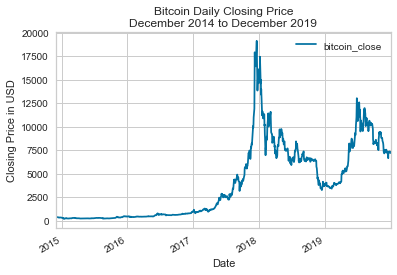

In [36]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

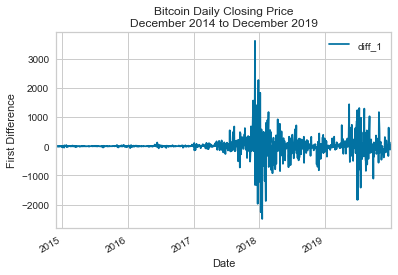

In [37]:
# Take first difference
diff = final[['date']].copy()
diff['diff_1'] = final.bitcoin_close - final.bitcoin_close.shift()

# Plot first difference to see if data set is stationary
diff.plot(x='date', y='diff_1')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

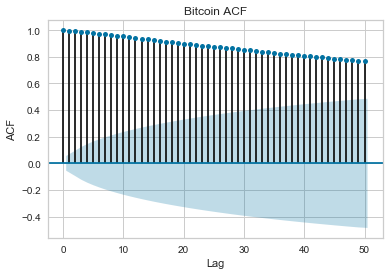

In [38]:
# Use ACF to find most optimal MA(q) model
plot_acf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

Autocorrelations are significant for a large number of lags (50+).

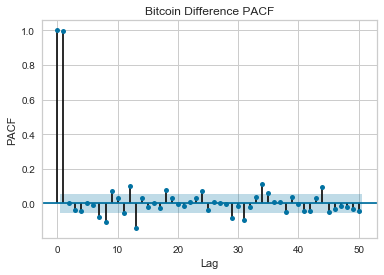

In [39]:
# Use PACF to find most optimal AR(p) model
plot_pacf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

However, the PACF plot indicates that the autocorrelations seen in the ACF plot are largely due to the propagation of the autocorrelation at lag 1.

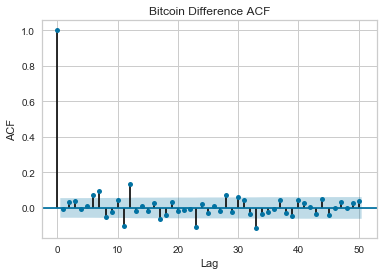

In [40]:
# Use ACF to find most optimal MA(q) model
plot_acf(diff['diff_1'][1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The ACF cuts off at lag 0, suggesting that an MA term is not needed for the differenced series.

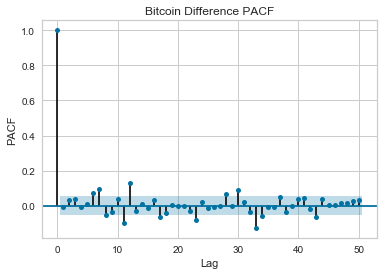

In [41]:
# Use PACF to find most optimal AR(p) model
plot_pacf(diff.diff_1[1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The PACF cuts off at lag 0, suggesting that an AR term is not needed for the differenced series. Based on these analyses, I will first try an ARIMA(0, 1, 0) model.

In [42]:
# Build ARIMA(0, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1261
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9095.381
Method:                           css   S.D. of innovations            328.289
Date:                Sun, 12 Apr 2020   AIC                          18194.762
Time:                        20:31:51   BIC                          18205.041
Sample:                             1   HQIC                         18198.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4039      9.245      0.585      0.559     -12.716      23.523


In [43]:
# Build ARIMA(1, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1261
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9095.342
Method:                       css-mle   S.D. of innovations            328.278
Date:                Sun, 12 Apr 2020   AIC                          18196.684
Time:                        20:31:51   BIC                          18212.103
Sample:                             1   HQIC                         18202.478
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.4039      9.172      0.589      0.556     -12.573      23.381
ar.L1.D.bitcoin_close    -0.0079      0.028     -0.280      0.779      -0.063       0.047
        

In [44]:
# Build ARIMA(0, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1261
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9095.344
Method:                       css-mle   S.D. of innovations            328.279
Date:                Sun, 12 Apr 2020   AIC                          18196.688
Time:                        20:31:51   BIC                          18212.107
Sample:                             1   HQIC                         18202.482
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.4039      9.176      0.589      0.556     -12.581      23.388
ma.L1.D.bitcoin_close    -0.0074      0.027     -0.272      0.785      -0.061       0.046
        

In [45]:
# Build ARIMA(1, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1261
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9095.280
Method:                       css-mle   S.D. of innovations            328.262
Date:                Sun, 12 Apr 2020   AIC                          18198.560
Time:                        20:31:51   BIC                          18219.118
Sample:                             1   HQIC                         18206.285
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.4039      9.160      0.590      0.555     -12.548      23.356
ar.L1.D.bitcoin_close    -0.3140      0.759     -0.414      0.679      -1.801       1.173
ma.L1.D.

The p-values for the AR and MR coefficients in the ARIMA(1, 1, 0), ARIMA(0, 1, 1), and ARIMA(1, 1, 1) are greater than 0.05, indicating that these coefficients do not play a significant explanatory role (and thus are not needed) when d=1.

In [46]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(final.bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18196.071, BIC=18216.630, Time=0.548 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18194.762, BIC=18205.041, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18196.684, BIC=18212.103, Time=0.037 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18196.694, BIC=18212.113, Time=0.074 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=18193.104, BIC=18198.244, Time=0.016 seconds
Total fit time: 0.711 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1262
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9095.552
Date:                Sun, 12 Apr 2020   AIC                          18193.104
Time:                        20:31:52   BIC                          18198.244
Sample:                             0   HQIC                         18195.036
                               - 1262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.077e+05   1140.359     94.459      0.000    1.05e+05     1.1e+05
===================================================================================
Ljung-Box (Q):                      135.00   Jarque-Bera (JB):             36231.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             488.58   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

pm.auto_arima also confirmed that ARIMA(0, 1, 0) is the best model (smallest AIC value).

In [47]:
# Use ARIMA(0, 1, 0) model to forecast bitcoin prices
# Instantiate model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,arima_forecast
0,7200.174316,2020-01-01,7491.324569,7199.003050
1,6985.470215,2020-01-02,7447.081397,7204.406978
2,7344.884277,2020-01-03,7439.084870,7209.810907
3,7410.656738,2020-01-04,6749.852761,7215.214836
4,7411.317383,2020-01-05,6719.003168,7220.618765
...,...,...,...,...
85,6716.440430,2020-03-26,7928.519463,7658.336992
86,6469.798340,2020-03-27,7995.008030,7663.740920
87,6242.193848,2020-03-28,7382.027573,7669.144849
88,5922.042969,2020-03-29,7428.896153,7674.548778


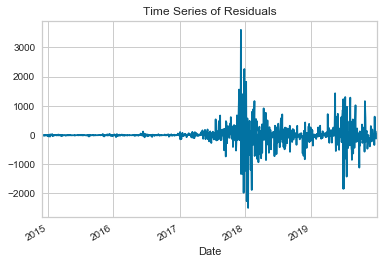

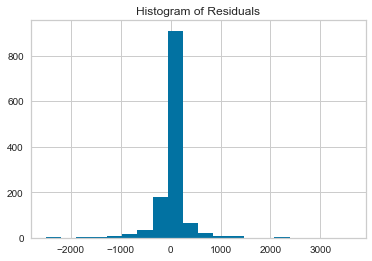

In [48]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

plt.show()

There isn't a clear trend in the residuals, indicating that seasonality is not playing a signficant role; however, there are a few places of higher volatility (beginning of 2018 and middle of 2019). Additionally, the distribution of the residuals seems approximately normal.

In [49]:
# Use RMSE and MAE to evaluate performance of ARIMA model
print('ARIMA(0, 1, 0) Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['arima_forecast']))

ARIMA(0, 1, 0) Performance

Root mean squared error: 1732.07

Mean absolute error: 1572.77


### Ensemble Model: Linear Regression or Random Forest Regressor Plus ARIMA
Finally, I will use an ensemble modeling approach in which I will predict bitcoin prices using a supervised learning model (linear regression or random forest regressor) and then feed those predicted prices into an ARIMA model.

# HELP: What is the advantage of this model? Why does predicting bitcoin prices based on external variables/features lead to a more accurate ARIMA forecast?

#### Select Features Using PCA

In [50]:
# Set feature and target variables
X = final[['cpi_close', 'dow_close', 'sp_close', 'usd_close', 'vix_close', 'interest', 'trend', 'unemploy']]
y = final['bitcoin_close']

# Standardize features
X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component:\n',
    pca.explained_variance_ratio_,
    '\n\nThe cumulative percentage of total variance in the dataset explained by',
    'the components:\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component:
 [6.17815126e-01 1.58304721e-01 1.37411522e-01 6.12636253e-02
 1.53188282e-02 7.33118149e-03 2.34151312e-03 2.13483003e-04] 

The cumulative percentage of total variance in the dataset explained by the components:
 [0.61781513 0.77611985 0.91353137 0.97479499 0.99011382 0.997445
 0.99978652 1.        ]


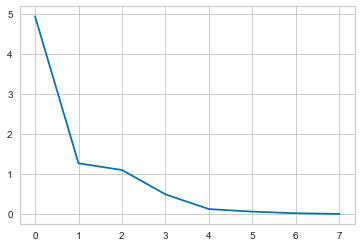

[4.94644053e+00 1.26744208e+00 1.10016394e+00 4.90497669e-01
 1.22647811e-01 5.86959622e-02 1.87469599e-02 1.70921840e-03]


In [51]:
# Print scree plot
Xt = X.T
Cx = np.cov(Xt)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

# HELP: Is this true?

Since I only have 8 variables, I used PCA to reduce correlation and improve independence between the external variables rather than to reduce the overall dimensions. Thus, I will continue with all 8 components as features in the downstream supervised models.

In [52]:
# Use all 8 components as features in model
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)
X_pca = pd.DataFrame(data=principal_components)
X_pca

,0,1,2,3,4,5,6,7
0,-2.547681,2.478968,0.176850,-1.835637,-0.129975,0.289281,0.095561,-0.010513
1,-2.465835,2.299681,-0.165317,-1.788511,-0.181937,0.331812,0.072516,-0.007363
2,-2.407985,2.218986,-0.286352,-1.769852,-0.118880,0.327020,0.019004,-0.007744
3,-2.467647,2.294106,-0.268257,-1.799357,-0.225580,0.340634,0.114317,0.000089
4,-2.455532,2.130925,-0.433353,-1.708032,-0.218566,0.360843,0.110320,-0.009227
...,...,...,...,...,...,...,...,...
1257,3.689347,-1.092802,-0.611479,-0.495378,1.177652,-0.104088,0.263454,0.049215
1258,3.759880,-1.077771,-0.599748,-0.530016,1.219638,-0.093239,0.235133,0.064200
1259,3.768874,-0.904601,-0.389663,-0.626311,1.310738,-0.133521,0.224565,0.055312
1260,3.163051,-0.845069,0.083859,-0.354369,0.734541,0.013590,0.932646,0.120055


#### Linear Regression Model

In [53]:
# Create training and testing sets from X_pca and y
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1234)

In [54]:
# Instantiate model
lrm = linear_model.LinearRegression()

# Fit model
lrm.fit(X_train, y_train)

# Use model to predict prices in X_test
y_pred = lrm.predict(X_test)

# Evaluate performance of model on test set
print('Coefficients:\n', lrm.coef_)

print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))

Coefficients:
 [1558.96932902  968.31918612  250.63691572 1087.59686964 1729.89855922
  490.40714096  298.35582677 5605.5717548 ]

Mean squared error: 1563122.81

Root mean squared error: 1250.25

R squared: 0.91


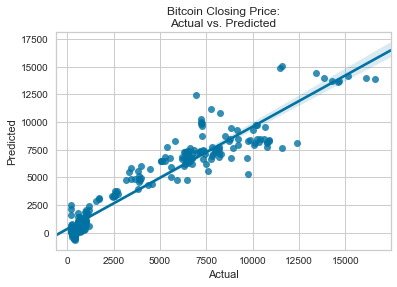

In [55]:
# Look at correlation between actual and predicted prices
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

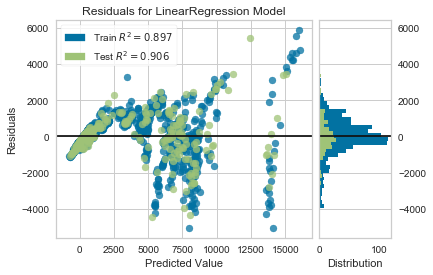

In [56]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(linear_model.LinearRegression(), X_train, y_train, X_test, y_test)

The R-squared values for both the training and test sets are quite high (about 0.9) and similar, suggesting that the model is not overfitting. However, there is some pattern to the residuals, indicating that there is room for improvement.

#### Random Forest Regressor

In [57]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_train, y_train)

# Use model to predict prices in X_test
y_pred = rfr.predict(X_test)

In [58]:
# # Evaluate performance of model on test set
print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))


Mean squared error: 443485.53

Root mean squared error: 665.95

R squared: 0.97


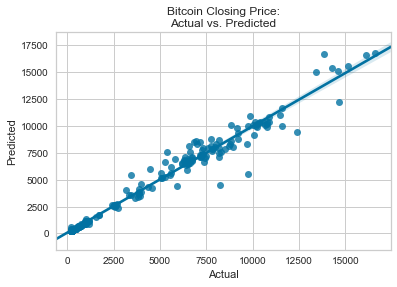

In [59]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

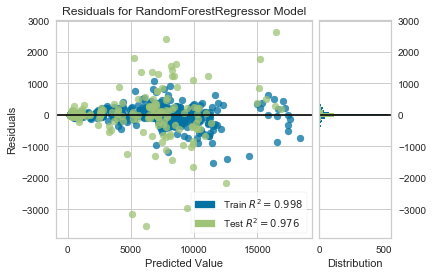

In [60]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

The random forest regressor performed significantly better than the linear regressor, as indicated by increased R-squared values for both the training and test sets, as well as more random residuals (no pattern). Thus, I will use the predictions from the random forest model, rather than the linear regression model, to feed into the ARIMA model.

#### Random Forest Regressor ARIMA Ensemble Model

In [61]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_pca, y)

# Use model to predict bitcoin prices
y_pred = rfr.predict(X_pca)

# Store predicted values in a new data frame
rfr_final = final[['date']].copy()
rfr_final['rfr_bitcoin_close'] = y_pred

# Check data frame
rfr_final

,date,rfr_bitcoin_close
0,2014-12-01,371.491977
1,2014-12-02,378.414073
2,2014-12-03,373.704557
3,2014-12-04,372.773293
4,2014-12-05,367.277573
...,...,...
1257,2019-12-23,7286.820254
1258,2019-12-26,7247.187031
1259,2019-12-27,7145.169937
1260,2019-12-30,7779.768789


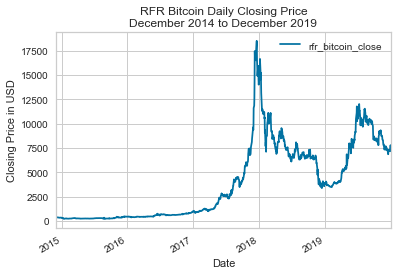

In [62]:
# Plot rfr predicted bitcoin time series
rfr_final.plot(x='date', y='rfr_bitcoin_close')
plt.title('RFR Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

In [63]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(rfr_final.rfr_bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=17805.530, BIC=17826.089, Time=0.103 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=17801.502, BIC=17811.781, Time=0.029 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=17803.484, BIC=17818.903, Time=0.040 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=17803.492, BIC=17818.911, Time=0.148 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=17800.000, BIC=17805.139, Time=0.027 seconds
Total fit time: 0.352 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1262
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8899.000
Date:                Sun, 12 Apr 2020   AIC                          17800.000
Time:                        20:31:59   BIC                          17805.139
Sample:                             0   HQIC                         17801.931
                               - 1262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.887e+04    898.537     87.773      0.000    7.71e+04    8.06e+04
===================================================================================
Ljung-Box (Q):                      104.74   Jarque-Bera (JB):             26435.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             269.76   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
# Forecast using ARIMA(0, 1, 0) model
# Instantiate model
model = ARIMA(rfr_final.rfr_bitcoin_close, order=(0, 1, 0))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['rfr_arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,arima_forecast,rfr_arima_forecast
0,7200.174316,2020-01-01,7491.324569,7199.003050,7410.832074
1,6985.470215,2020-01-02,7447.081397,7204.406978,7416.409998
2,7344.884277,2020-01-03,7439.084870,7209.810907,7421.987922
3,7410.656738,2020-01-04,6749.852761,7215.214836,7427.565846
4,7411.317383,2020-01-05,6719.003168,7220.618765,7433.143770
...,...,...,...,...,...
85,6716.440430,2020-03-26,7928.519463,7658.336992,7884.955615
86,6469.798340,2020-03-27,7995.008030,7663.740920,7890.533539
87,6242.193848,2020-03-28,7382.027573,7669.144849,7896.111463
88,5922.042969,2020-03-29,7428.896153,7674.548778,7901.689387


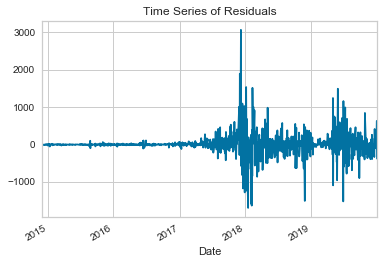

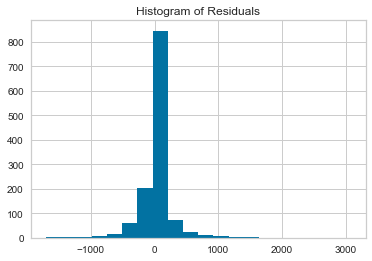

In [65]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

plt.show()

As seen previously, there is no clear pattern in the residuals and the distribution is approximately normal.

In [66]:
# # Evaluate performance of model on test set
print('Random Forest and ARIMA(1, 1, 2) Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['rfr_arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['rfr_arima_forecast']))

Random Forest and ARIMA(1, 1, 2) Performance

Root mean squared error: 1637.85

Mean absolute error: 1460.48


## Results Summary

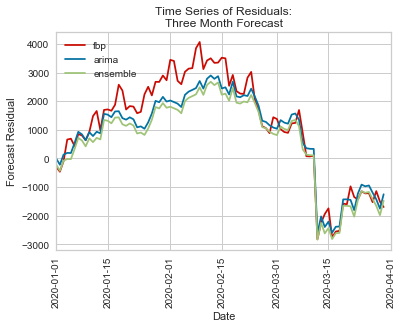

In [67]:
plt.plot(actual['date'], actual['actual_close'] - actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['actual_close'] - actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['actual_close'] - actual['rfr_arima_forecast'], c='g', label='ensemble')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nThree Month Forecast')
plt.legend(loc='upper left')

plt.show()

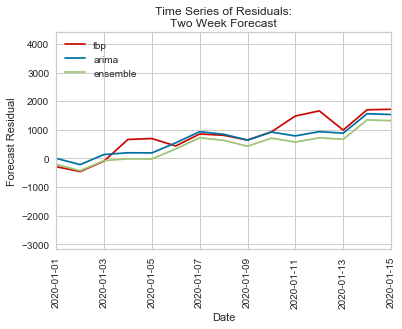

In [68]:
plt.plot(actual['date'], actual['actual_close'] - actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['actual_close'] - actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['actual_close'] - actual['rfr_arima_forecast'], c='g', label='ensemble')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 1, 15)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nTwo Week Forecast')
plt.legend(loc='upper left')

plt.show()

# TO DO:
Compare RMSE and MAE for all models. Talk about high predictive accuracy within two weeks.

## Data Product Summary